In [ ]:
# Cell 1: Setup Environment dan Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter, defaultdict
import gc
import os
import pickle
import time

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Memory monitoring
import psutil

def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def print_memory_status(stage=""):
    """Print memory status"""
    gc.collect()
    memory_mb = get_memory_usage()
    print(f"💾 Memory usage {stage}: {memory_mb:.1f} MB")
    return memory_mb

print("🚀 Environment setup complete!")
print_memory_status("initial")

🚀 Environment setup complete!
💾 Memory usage initial: 217.2 MB


217.24609375

In [ ]:
# Cell 2: Mount Google Drive dan Setup Paths
from google.colab import drive
drive.mount('/content/drive')

# Define paths
ROOT_PATH = '/content/drive/MyDrive/TA/DIEN/DIEN-tf2/new/dataset'
CHECKPOINT_PATH = '/content/drive/MyDrive/TA/TAOBAO/checkpoints'
MODEL_SAVE_PATH = '/content/drive/MyDrive/TA/TAOBAO/models'
PLOTS_PATH = '/content/drive/MyDrive/TA/TAOBAO/plots'

# Create directories
for path in [CHECKPOINT_PATH, MODEL_SAVE_PATH, PLOTS_PATH]:
    os.makedirs(path, exist_ok=True)

# File paths
RAW_SAMPLE_PATH = os.path.join(ROOT_PATH, 'raw_sample.csv')
AD_FEATURE_PATH = os.path.join(ROOT_PATH, 'ad_feature.csv')
USER_PROFILE_PATH = os.path.join(ROOT_PATH, 'user_profile.csv')
USER_BEHAVIOR_PATH = os.path.join(ROOT_PATH, 'UserBehavior.csv')

# Checkpoint files
EDA_CHECKPOINT = os.path.join(CHECKPOINT_PATH, 'eda_results.pkl')
PREPROCESSED_CHECKPOINT = os.path.join(CHECKPOINT_PATH, 'preprocessed_data.pkl')

print("📁 Paths configured successfully!")
print(f"🗂️ Dataset root: {ROOT_PATH}")
print(f"💾 Checkpoints: {CHECKPOINT_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📁 Paths configured successfully!
🗂️ Dataset root: /content/drive/MyDrive/TA/DIEN/DIEN-tf2/new/dataset
💾 Checkpoints: /content/drive/MyDrive/TA/TAOBAO/checkpoints


In [ ]:
# Cell 3: Data Loading Functions with Memory Optimization
def load_data_sample(file_path, sample_size=None, **kwargs):
    """Load data with optional sampling for large files"""
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        return None

    print(f"📂 Loading {os.path.basename(file_path)}...")

    if sample_size:
        # For very large files, use sampling
        total_lines = sum(1 for line in open(file_path)) - 1  # -1 for header
        if total_lines > sample_size:
            skip_rows = sorted(np.random.choice(range(1, total_lines + 1),
                                              total_lines - sample_size,
                                              replace=False))
            df = pd.read_csv(file_path, skiprows=skip_rows, **kwargs)
            print(f"📊 Sampled {len(df):,} rows from {total_lines:,} total rows")
        else:
            df = pd.read_csv(file_path, **kwargs)
    else:
        df = pd.read_csv(file_path, **kwargs)

    print(f"✅ Loaded {len(df):,} rows, {len(df.columns)} columns")
    print_memory_status(f"after loading {os.path.basename(file_path)}")

    return df

def optimize_dtypes(df):
    """Optimize dataframe dtypes to reduce memory usage"""
    original_memory = df.memory_usage(deep=True).sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)

    new_memory = df.memory_usage(deep=True).sum() / 1024**2
    print(f"💾 Memory optimized: {original_memory:.1f}MB → {new_memory:.1f}MB ({100 * (original_memory - new_memory) / original_memory:.1f}% reduction)")

    return df

print("🔧 Data loading functions ready!")

🔧 Data loading functions ready!


In [ ]:
# Cell 4: Load Raw Sample Data untuk EDA
def load_raw_sample_for_eda():
    """Load raw sample data with appropriate sampling for EDA"""

    # For EDA, we can work with a reasonable sample
    # Adjust sample_size based on your Colab memory capacity
    SAMPLE_SIZE = 1000000  # 1M samples for EDA

    print("📊 Loading raw sample data for EDA...")

    # Define columns to load
    raw_sample_cols = ['user', 'time_stamp', 'adgroup_id', 'pid', 'nonclk', 'clk']

    raw_sample = load_data_sample(
        RAW_SAMPLE_PATH,
        sample_size=SAMPLE_SIZE,
        usecols=raw_sample_cols
    )

    if raw_sample is not None:
        # Basic cleaning
        raw_sample = raw_sample.rename(columns={'user': 'userid'})
        raw_sample = optimize_dtypes(raw_sample)

        # Create datetime from timestamp
        raw_sample['datetime'] = pd.to_datetime(raw_sample['time_stamp'], unit='s')

        print(f"✅ Raw sample loaded: {len(raw_sample):,} rows")
        print(f"📅 Date range: {raw_sample['datetime'].min()} to {raw_sample['datetime'].max()}")

    return raw_sample

# Load data
raw_sample = load_raw_sample_for_eda()
print("\n📋 Raw sample info:")
print(raw_sample.info())
print("\n📊 First 5 rows:")
print(raw_sample.head())

📊 Loading raw sample data for EDA...
📂 Loading raw_sample.csv...
📊 Sampled 1,000,000 rows from 26,557,961 total rows
✅ Loaded 1,000,000 rows, 6 columns
💾 Memory usage after loading raw_sample.csv: 1362.1 MB
💾 Memory optimized: 95.4MB → 70.6MB (26.0% reduction)
✅ Raw sample loaded: 1,000,000 rows
📅 Date range: 2017-05-05 16:00:00 to 2017-05-13 15:59:33

📋 Raw sample info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   userid      1000000 non-null  int32         
 1   time_stamp  1000000 non-null  int32         
 2   adgroup_id  1000000 non-null  int32         
 3   pid         1000000 non-null  object        
 4   nonclk      1000000 non-null  int8          
 5   clk         1000000 non-null  int8          
 6   datetime    1000000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3), int8(2), object(1)
memory us

In [ ]:
# Cell 5: Basic Data Quality Assessment
def assess_data_quality(df, name="Dataset"):
    """Comprehensive data quality assessment"""

    print(f"\n🔍 DATA QUALITY ASSESSMENT: {name}")
    print("=" * 60)

    # Basic info
    print(f"📊 Shape: {df.shape}")
    print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

    # Missing values
    print(f"\n❌ Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100

    for col in df.columns:
        if missing[col] > 0:
            print(f"   {col}: {missing[col]:,} ({missing_pct[col]:.2f}%)")

    if missing.sum() == 0:
        print("   ✅ No missing values found!")

    # Duplicates
    duplicates = df.duplicated().sum()
    print(f"\n🔄 Duplicates: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

    # Data types
    print(f"\n📋 Data Types:")
    for dtype in df.dtypes.value_counts().index:
        count = df.dtypes.value_counts()[dtype]
        cols = df.select_dtypes(include=[dtype]).columns.tolist()
        print(f"   {dtype}: {count} columns {cols[:3]}{'...' if len(cols) > 3 else ''}")

    # Unique values
    print(f"\n🎯 Unique Values (top 10 by cardinality):")
    unique_counts = df.nunique().sort_values(ascending=False)
    for col in unique_counts.head(10).index:
        unique_ratio = unique_counts[col] / len(df)
        print(f"   {col}: {unique_counts[col]:,} ({unique_ratio:.3f})")

    return {
        'missing_values': missing,
        'duplicates': duplicates,
        'unique_counts': unique_counts,
        'shape': df.shape
    }

# Assess raw sample quality
if raw_sample is not None:
    quality_report = assess_data_quality(raw_sample, "Raw Sample")


🔍 DATA QUALITY ASSESSMENT: Raw Sample
📊 Shape: (1000000, 7)
💾 Memory usage: 78.2 MB

❌ Missing Values:
   ✅ No missing values found!

🔄 Duplicates: 0 (0.00%)

📋 Data Types:
   int32: 3 columns ['userid', 'time_stamp', 'adgroup_id']
   int8: 2 columns ['nonclk', 'clk']
   object: 1 columns ['pid']
   datetime64[ns]: 1 columns ['datetime']

🎯 Unique Values (top 10 by cardinality):
   time_stamp: 460,523 (0.461)
   datetime: 460,523 (0.461)
   userid: 403,381 (0.403)
   adgroup_id: 243,216 (0.243)
   pid: 2 (0.000)
   nonclk: 2 (0.000)
   clk: 2 (0.000)



🎯 TARGET VARIABLE ANALYSIS
📊 Click Distribution:
   No Click (0): 948,512 (94.85%)
   Click (1): 51,488 (5.15%)
   ⚖️ Imbalance Ratio: 1:18.4


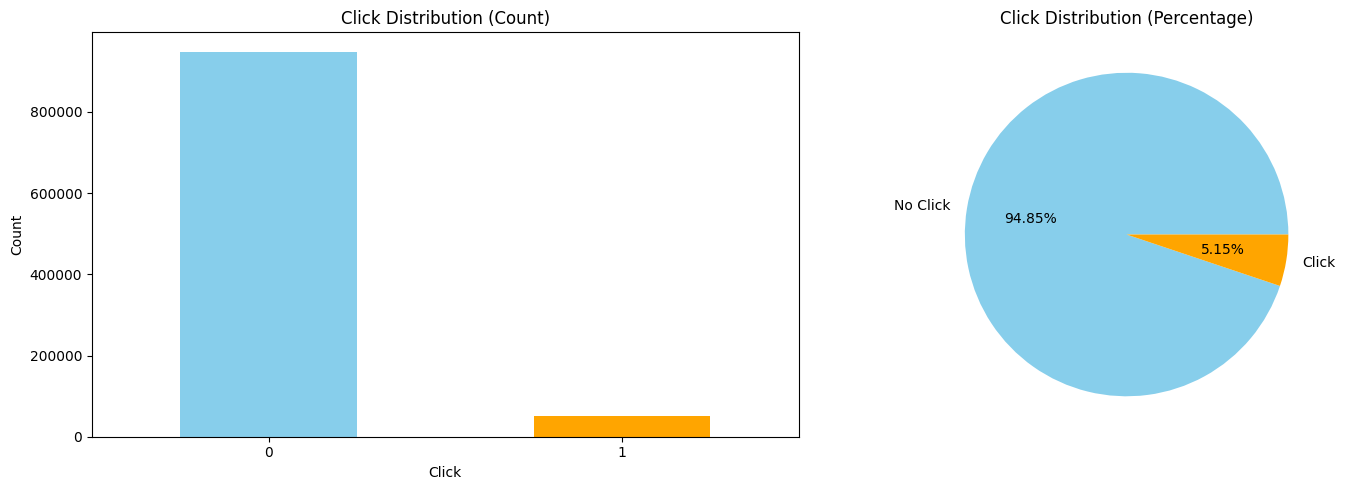


📅 CTR by Time Patterns:
   📈 Hourly CTR range: 0.0441 - 0.0534
   📈 Daily CTR range: 0.0486 - 0.0540


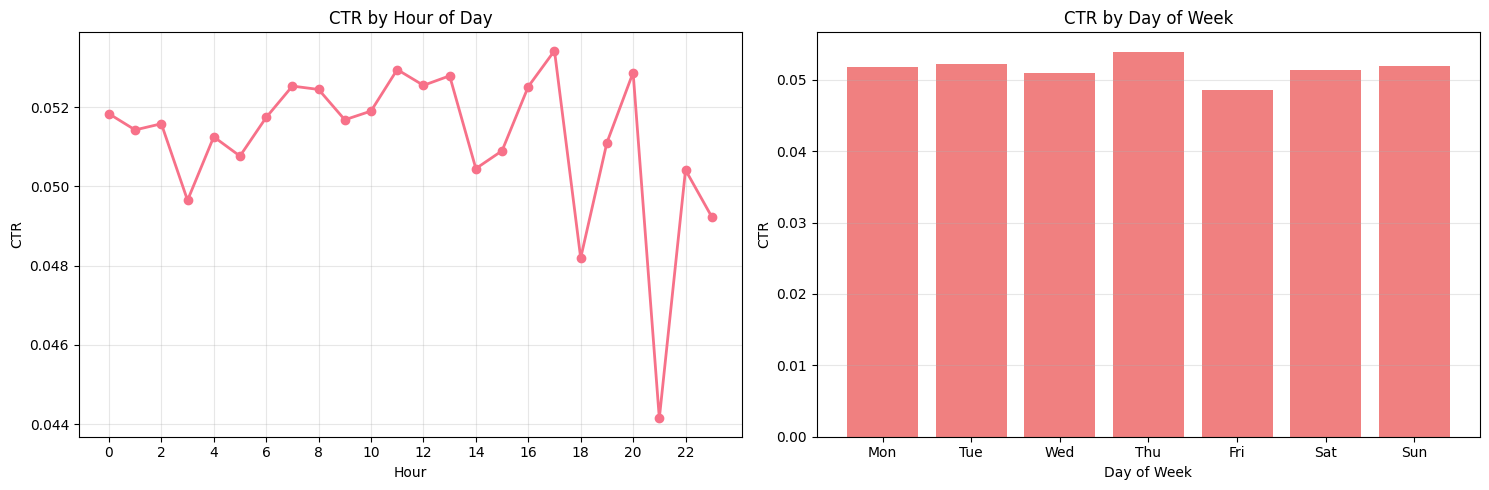

In [ ]:
# Cell 6: Target Variable Analysis
def analyze_target_variable(df):
    """Comprehensive target variable analysis"""

    print("\n🎯 TARGET VARIABLE ANALYSIS")
    print("=" * 50)

    # Class distribution
    if 'clk' in df.columns:
        target_dist = df['clk'].value_counts().sort_index()
        target_pct = df['clk'].value_counts(normalize=True).sort_index() * 100

        print(f"📊 Click Distribution:")
        print(f"   No Click (0): {target_dist[0]:,} ({target_pct[0]:.2f}%)")
        print(f"   Click (1): {target_dist[1]:,} ({target_pct[1]:.2f}%)")

        # Calculate imbalance ratio
        imbalance_ratio = target_dist[0] / target_dist[1]
        print(f"   ⚖️ Imbalance Ratio: 1:{imbalance_ratio:.1f}")

        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Bar plot
        target_dist.plot(kind='bar', ax=axes[0], color=['skyblue', 'orange'])
        axes[0].set_title('Click Distribution (Count)')
        axes[0].set_xlabel('Click')
        axes[0].set_ylabel('Count')
        axes[0].tick_params(axis='x', rotation=0)

        # Pie chart
        axes[1].pie(target_dist.values, labels=['No Click', 'Click'],
                   autopct='%1.2f%%', colors=['skyblue', 'orange'])
        axes[1].set_title('Click Distribution (Percentage)')

        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_PATH, 'target_distribution.png'), dpi=300, bbox_inches='tight')
        plt.show()

        # CTR by time patterns
        if 'datetime' in df.columns:
            print(f"\n📅 CTR by Time Patterns:")

            # Add time features
            df['hour'] = df['datetime'].dt.hour
            df['day_of_week'] = df['datetime'].dt.dayofweek
            df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

            # CTR by hour
            hourly_ctr = df.groupby('hour')['clk'].agg(['count', 'sum', 'mean']).reset_index()
            hourly_ctr['ctr'] = hourly_ctr['mean']

            print(f"   📈 Hourly CTR range: {hourly_ctr['ctr'].min():.4f} - {hourly_ctr['ctr'].max():.4f}")

            # CTR by day of week
            daily_ctr = df.groupby('day_of_week')['clk'].agg(['count', 'sum', 'mean']).reset_index()
            daily_ctr['ctr'] = daily_ctr['mean']

            print(f"   📈 Daily CTR range: {daily_ctr['ctr'].min():.4f} - {daily_ctr['ctr'].max():.4f}")

            # Visualize temporal patterns
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))

            # Hourly CTR
            axes[0].plot(hourly_ctr['hour'], hourly_ctr['ctr'], marker='o', linewidth=2, markersize=6)
            axes[0].set_title('CTR by Hour of Day')
            axes[0].set_xlabel('Hour')
            axes[0].set_ylabel('CTR')
            axes[0].grid(True, alpha=0.3)
            axes[0].set_xticks(range(0, 24, 2))

            # Daily CTR
            day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
            axes[1].bar(range(7), daily_ctr['ctr'], color='lightcoral')
            axes[1].set_title('CTR by Day of Week')
            axes[1].set_xlabel('Day of Week')
            axes[1].set_ylabel('CTR')
            axes[1].set_xticks(range(7))
            axes[1].set_xticklabels(day_names)
            axes[1].grid(True, alpha=0.3, axis='y')

            plt.tight_layout()
            plt.savefig(os.path.join(PLOTS_PATH, 'temporal_ctr_patterns.png'), dpi=300, bbox_inches='tight')
            plt.show()

        return {
            'class_distribution': target_dist,
            'class_percentage': target_pct,
            'imbalance_ratio': imbalance_ratio,
            'hourly_ctr': hourly_ctr if 'datetime' in df.columns else None,
            'daily_ctr': daily_ctr if 'datetime' in df.columns else None
        }

    else:
        print("❌ Target variable 'clk' not found in dataset")
        return None

# Analyze target variable
if raw_sample is not None:
    target_analysis = analyze_target_variable(raw_sample)

In [ ]:
# Cell 7: Load Additional Features untuk EDA
def load_additional_features_for_eda():
    """Load additional feature files for comprehensive EDA"""

    print("\n📊 Loading additional feature files...")

    # Load ad features
    print("🛍️ Loading ad features...")
    ad_features = load_data_sample(AD_FEATURE_PATH)
    if ad_features is not None:
        ad_features = optimize_dtypes(ad_features)
        print(f"   Ad features shape: {ad_features.shape}")

    # Load user profiles
    print("👤 Loading user profiles...")
    user_profiles = load_data_sample(USER_PROFILE_PATH)
    if user_profiles is not None:
        user_profiles = optimize_dtypes(user_profiles)
        print(f"   User profiles shape: {user_profiles.shape}")

    # Load user behavior (sample due to size)
    print("📱 Loading user behavior (sampled)...")
    behavior_sample_size = 1000000  # 500K for EDA

    # UserBehavior.csv doesn't have header, define column names
    behavior_columns = ['userid', 'itemid', 'categoryid', 'behavior', 'timestamp']

    user_behavior = load_data_sample(
        USER_BEHAVIOR_PATH,
        sample_size=behavior_sample_size,
        header=None,
        names=behavior_columns
    )

    if user_behavior is not None:
        user_behavior = optimize_dtypes(user_behavior)
        # Convert timestamp to datetime
        user_behavior['datetime'] = pd.to_datetime(user_behavior['timestamp'], unit='s')
        print(f"   User behavior shape: {user_behavior.shape}")

    return {
        'ad_features': ad_features,
        'user_profiles': user_profiles,
        'user_behavior': user_behavior
    }

# Load additional features
additional_data = load_additional_features_for_eda()
ad_features = additional_data['ad_features']
user_profiles = additional_data['user_profiles']
user_behavior = additional_data['user_behavior']

print("\n✅ Additional data loaded successfully!")
print_memory_status("after loading all data")


📊 Loading additional feature files...
🛍️ Loading ad features...
📂 Loading ad_feature.csv...
✅ Loaded 846,811 rows, 6 columns
💾 Memory usage after loading ad_feature.csv: 391.8 MB
💾 Memory optimized: 38.8MB → 17.8MB (54.2% reduction)
   Ad features shape: (846811, 6)
👤 Loading user profiles...
📂 Loading user_profile.csv...
✅ Loaded 1,061,768 rows, 9 columns
💾 Memory usage after loading user_profile.csv: 551.5 MB
💾 Memory optimized: 72.9MB → 18.2MB (75.0% reduction)
   User profiles shape: (1061768, 9)
📱 Loading user behavior (sampled)...
📂 Loading UserBehavior.csv...
📊 Sampled 1,000,001 rows from 100,150,806 total rows
✅ Loaded 1,000,001 rows, 5 columns
💾 Memory usage after loading UserBehavior.csv: 4186.4 MB
💾 Memory optimized: 79.3MB → 64.0MB (19.2% reduction)
   User behavior shape: (1000001, 6)

✅ Additional data loaded successfully!
💾 Memory usage after loading all data: 368.1 MB


368.078125


📱 USER BEHAVIOR ANALYSIS
📊 Behavior Type Distribution:
   pv: 895,737 (89.57%)
   cart: 55,182 (5.52%)
   fav: 28,795 (2.88%)
   buy: 20,287 (2.03%)


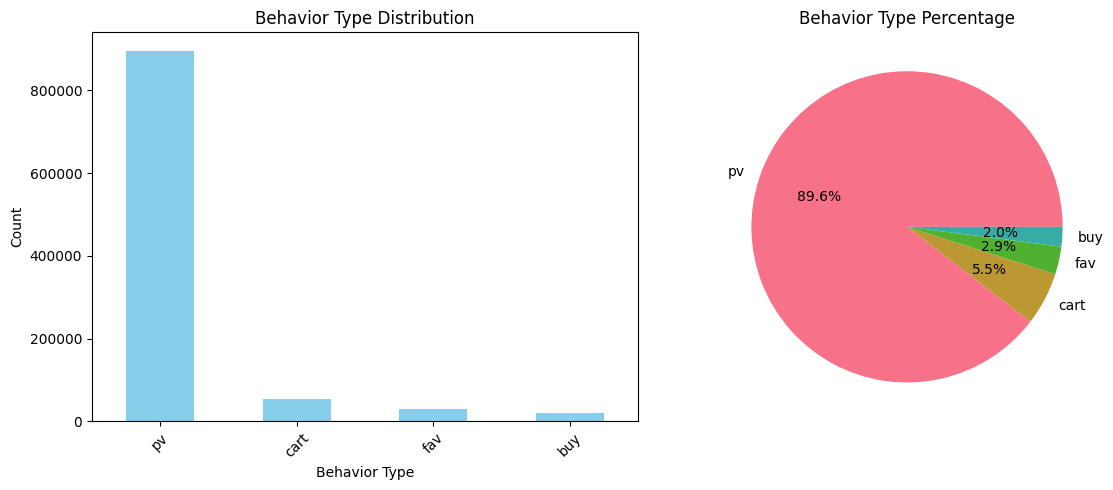


👤 User Activity Statistics:
   Total users: 527,432
   Avg actions per user: 1.9
   Avg unique items per user: 1.9
   Avg unique categories per user: 1.8


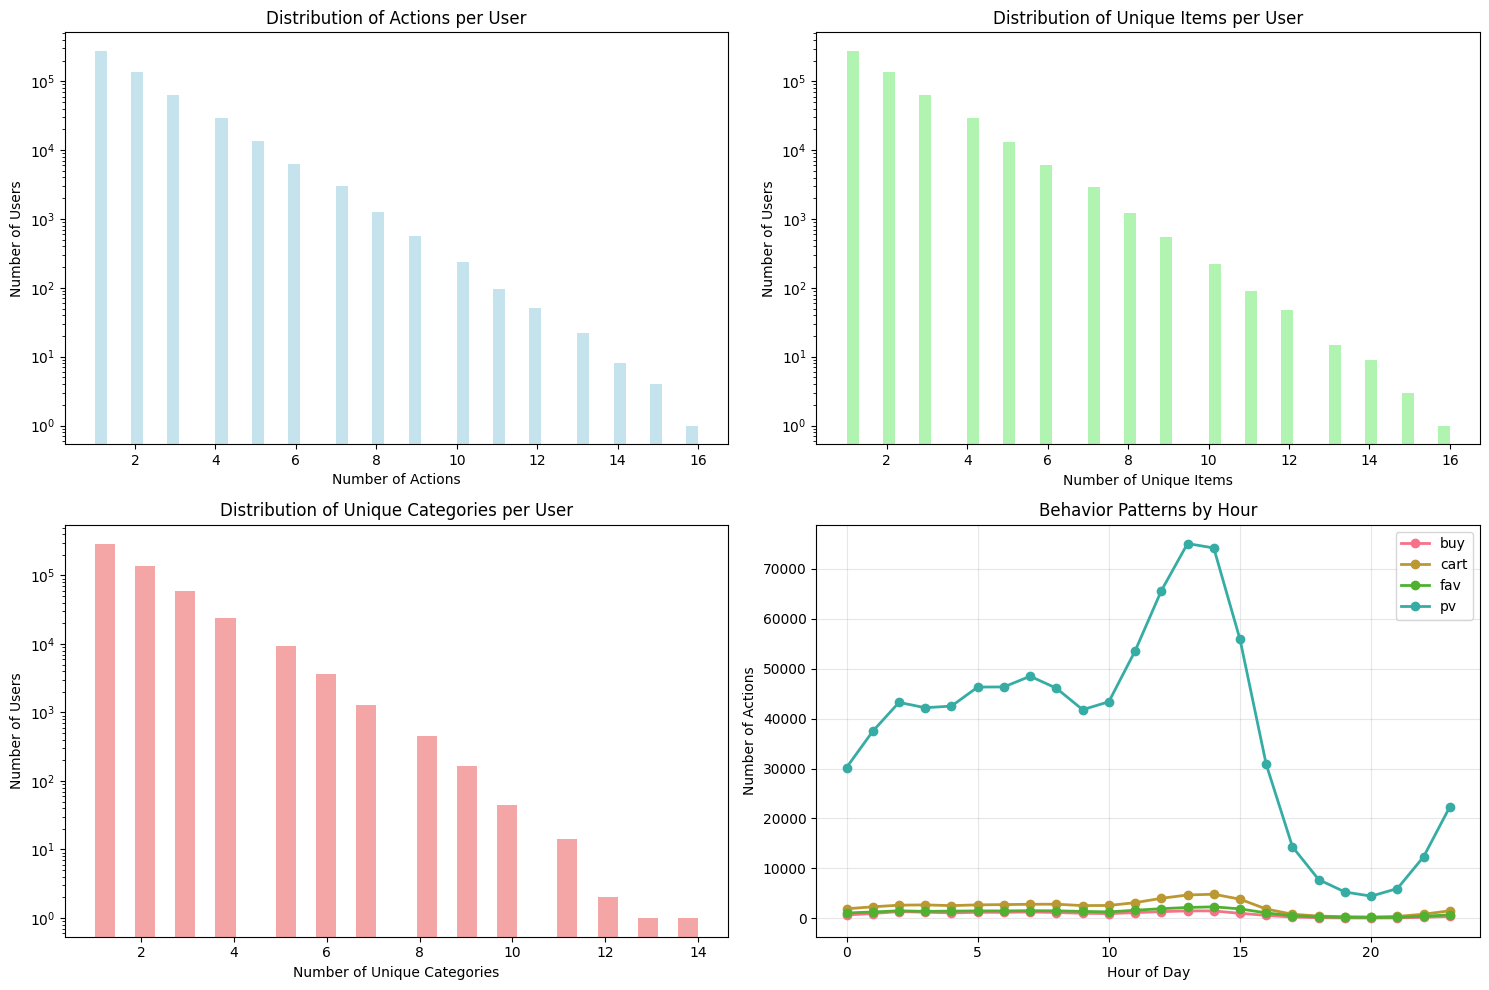

In [ ]:
# Cell 8: User Behavior Analysis
def analyze_user_behavior(behavior_df):
    """Analyze user behavior patterns"""

    if behavior_df is None:
        print("❌ No user behavior data available")
        return None

    print("\n📱 USER BEHAVIOR ANALYSIS")
    print("=" * 50)

    # Behavior type distribution
    behavior_dist = behavior_df['behavior'].value_counts()
    behavior_pct = behavior_df['behavior'].value_counts(normalize=True) * 100

    print(f"📊 Behavior Type Distribution:")
    for behavior, count in behavior_dist.items():
        pct = behavior_pct[behavior]
        print(f"   {behavior}: {count:,} ({pct:.2f}%)")

    # Visualize behavior distribution
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    behavior_dist.plot(kind='bar', color='skyblue')
    plt.title('Behavior Type Distribution')
    plt.xlabel('Behavior Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.pie(behavior_dist.values, labels=behavior_dist.index, autopct='%1.1f%%')
    plt.title('Behavior Type Percentage')

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, 'behavior_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # User activity analysis
    user_activity = behavior_df.groupby('userid').agg({
        'behavior': 'count',
        'itemid': 'nunique',
        'categoryid': 'nunique'
    }).rename(columns={
        'behavior': 'total_actions',
        'itemid': 'unique_items',
        'categoryid': 'unique_categories'
    })

    print(f"\n👤 User Activity Statistics:")
    print(f"   Total users: {len(user_activity):,}")
    print(f"   Avg actions per user: {user_activity['total_actions'].mean():.1f}")
    print(f"   Avg unique items per user: {user_activity['unique_items'].mean():.1f}")
    print(f"   Avg unique categories per user: {user_activity['unique_categories'].mean():.1f}")

    # Plot user activity distribution
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Actions per user
    axes[0,0].hist(user_activity['total_actions'], bins=50, alpha=0.7, color='lightblue')
    axes[0,0].set_title('Distribution of Actions per User')
    axes[0,0].set_xlabel('Number of Actions')
    axes[0,0].set_ylabel('Number of Users')
    axes[0,0].set_yscale('log')

    # Unique items per user
    axes[0,1].hist(user_activity['unique_items'], bins=50, alpha=0.7, color='lightgreen')
    axes[0,1].set_title('Distribution of Unique Items per User')
    axes[0,1].set_xlabel('Number of Unique Items')
    axes[0,1].set_ylabel('Number of Users')
    axes[0,1].set_yscale('log')

    # Unique categories per user
    axes[1,0].hist(user_activity['unique_categories'], bins=30, alpha=0.7, color='lightcoral')
    axes[1,0].set_title('Distribution of Unique Categories per User')
    axes[1,0].set_xlabel('Number of Unique Categories')
    axes[1,0].set_ylabel('Number of Users')
    axes[1,0].set_yscale('log')

    # Behavior temporal patterns
    if 'datetime' in behavior_df.columns:
        behavior_df['hour'] = behavior_df['datetime'].dt.hour
        hourly_behavior = behavior_df.groupby(['hour', 'behavior']).size().unstack(fill_value=0)

        for behavior_type in hourly_behavior.columns:
            axes[1,1].plot(hourly_behavior.index, hourly_behavior[behavior_type],
                          marker='o', label=behavior_type, linewidth=2)

        axes[1,1].set_title('Behavior Patterns by Hour')
        axes[1,1].set_xlabel('Hour of Day')
        axes[1,1].set_ylabel('Number of Actions')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, 'user_activity_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'behavior_distribution': behavior_dist,
        'user_activity_stats': user_activity.describe(),
        'total_users': len(user_activity)
    }

# Analyze user behavior
if user_behavior is not None:
    behavior_analysis = analyze_user_behavior(user_behavior)


🛍️ AD FEATURES ANALYSIS
📊 Ad Features Overview:
   Total ads: 846,811
   Features: ['adgroup_id', 'cate_id', 'campaign_id', 'customer', 'brand', 'price']
   Unique categories: 6,769

📂 Top 10 Categories by Ad Count:
    1. Category 6261: 42,691 ads (5.0%)
    2. Category 4520: 21,344 ads (2.5%)
    3. Category 1665: 15,443 ads (1.8%)
    4. Category 4282: 14,895 ads (1.8%)
    5. Category 6426: 14,159 ads (1.7%)
    6. Category 6423: 14,130 ads (1.7%)
    7. Category 4505: 13,495 ads (1.6%)
    8. Category 4280: 11,738 ads (1.4%)
    9. Category 4284: 11,044 ads (1.3%)
   10. Category 4283: 10,794 ads (1.3%)

🏷️ Brand Analysis:
   Unique brands: 99,814

🔝 Top 10 Brands by Ad Count:
    1. Brand 353787.0: 6,553 ads (0.8%)
    2. Brand 247789.0: 4,608 ads (0.5%)
    3. Brand 234846.0: 3,009 ads (0.4%)
    4. Brand 146115.0: 2,958 ads (0.3%)
    5. Brand 220468.0: 2,781 ads (0.3%)
    6. Brand 98931.0: 2,403 ads (0.3%)
    7. Brand 425589.0: 2,355 ads (0.3%)
    8. Brand 342760.0: 2,250 

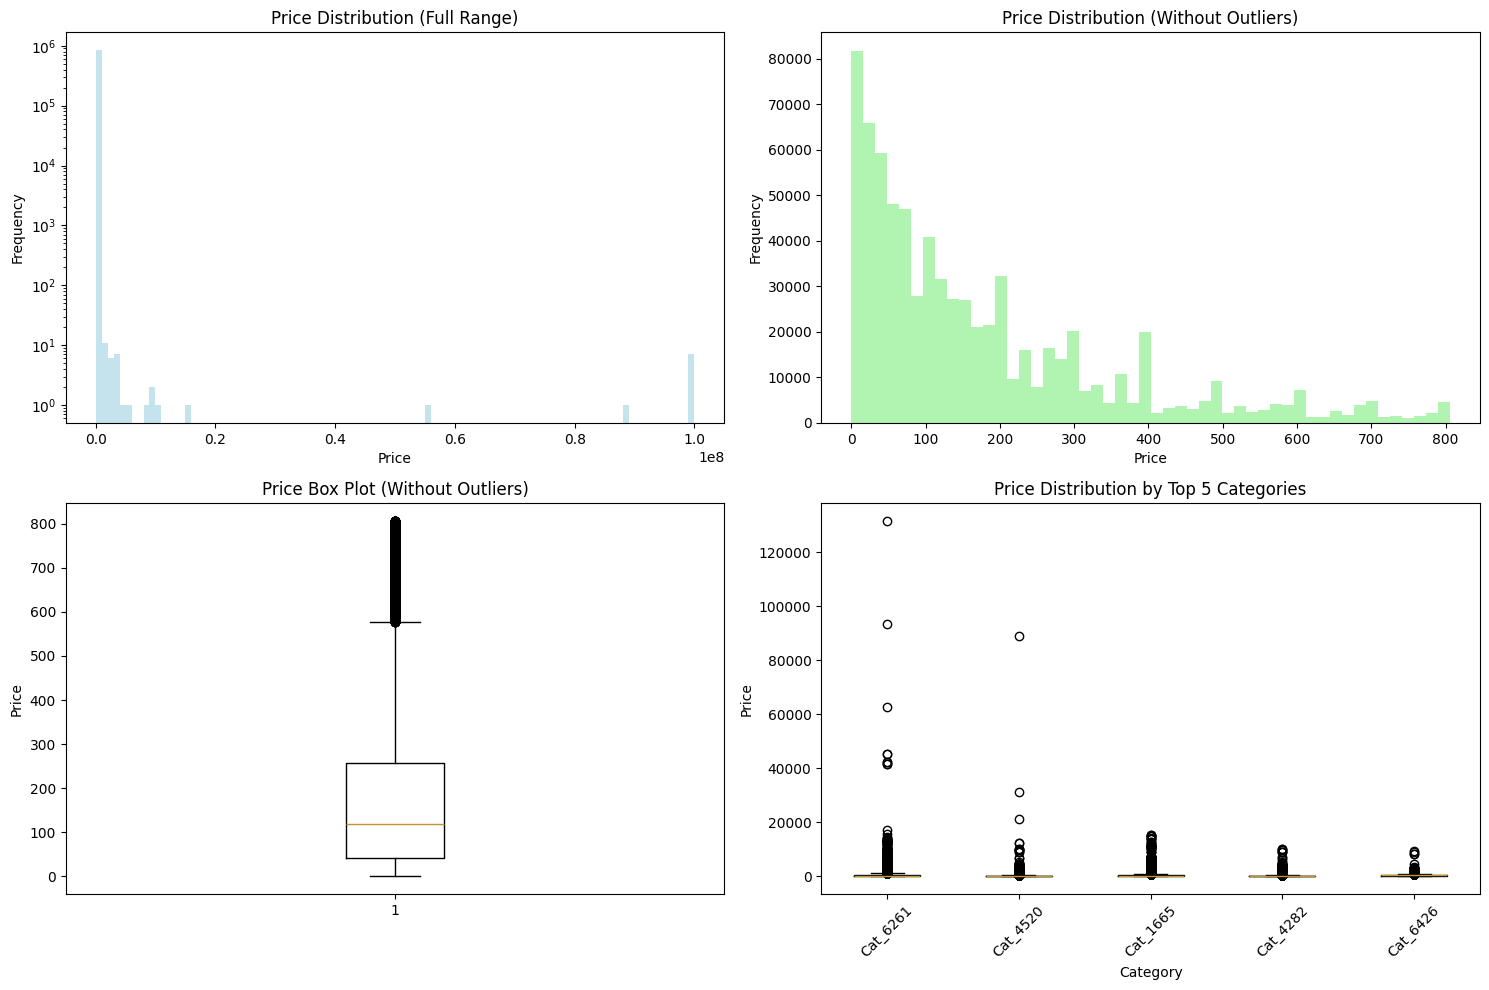


🔗 Category-Brand Relationship:
   Average brands per category: 33.0
   Average categories per brand: 2.1


In [ ]:
# Cell 9: Ad Features Analysis
def analyze_ad_features(ad_df):
    """Analyze ad features and product catalog"""

    if ad_df is None:
        print("❌ No ad features data available")
        return None

    print("\n🛍️ AD FEATURES ANALYSIS")
    print("=" * 50)

    print(f"📊 Ad Features Overview:")
    print(f"   Total ads: {len(ad_df):,}")
    print(f"   Features: {list(ad_df.columns)}")

    # Category analysis
    if 'cate_id' in ad_df.columns:
        n_categories = ad_df['cate_id'].nunique()
        print(f"   Unique categories: {n_categories:,}")

        # Top categories by ad count
        top_categories = ad_df['cate_id'].value_counts().head(10)
        print(f"\n📂 Top 10 Categories by Ad Count:")
        for idx, (cat_id, count) in enumerate(top_categories.items(), 1):
            pct = count / len(ad_df) * 100
            print(f"   {idx:2d}. Category {cat_id}: {count:,} ads ({pct:.1f}%)")

    # Brand analysis
    if 'brand' in ad_df.columns:
        n_brands = ad_df['brand'].nunique()
        print(f"\n🏷️ Brand Analysis:")
        print(f"   Unique brands: {n_brands:,}")

        # Top brands by ad count
        top_brands = ad_df['brand'].value_counts().head(10)
        print(f"\n🔝 Top 10 Brands by Ad Count:")
        for idx, (brand_id, count) in enumerate(top_brands.items(), 1):
            pct = count / len(ad_df) * 100
            print(f"   {idx:2d}. Brand {brand_id}: {count:,} ads ({pct:.1f}%)")

    # Price analysis
    if 'price' in ad_df.columns:
        # Remove outliers for visualization
        price_stats = ad_df['price'].describe()
        q1 = price_stats['25%']
        q3 = price_stats['75%']
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        print(f"\n💰 Price Analysis:")
        print(f"   Price range: {ad_df['price'].min():.2f} - {ad_df['price'].max():.2f}")
        print(f"   Mean price: {ad_df['price'].mean():.2f}")
        print(f"   Median price: {ad_df['price'].median():.2f}")
        print(f"   Std deviation: {ad_df['price'].std():.2f}")

        # Price distribution visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Full price distribution
        axes[0,0].hist(ad_df['price'], bins=100, alpha=0.7, color='lightblue')
        axes[0,0].set_title('Price Distribution (Full Range)')
        axes[0,0].set_xlabel('Price')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].set_yscale('log')

        # Price distribution without outliers
        price_filtered = ad_df[(ad_df['price'] >= lower_bound) & (ad_df['price'] <= upper_bound)]['price']
        axes[0,1].hist(price_filtered, bins=50, alpha=0.7, color='lightgreen')
        axes[0,1].set_title('Price Distribution (Without Outliers)')
        axes[0,1].set_xlabel('Price')
        axes[0,1].set_ylabel('Frequency')

        # Box plot
        axes[1,0].boxplot(price_filtered)
        axes[1,0].set_title('Price Box Plot (Without Outliers)')
        axes[1,0].set_ylabel('Price')

        # Price by top categories
        if 'cate_id' in ad_df.columns:
            top_cats = ad_df['cate_id'].value_counts().head(5).index
            price_by_cat = [ad_df[ad_df['cate_id'] == cat]['price'] for cat in top_cats]

            axes[1,1].boxplot(price_by_cat, labels=[f'Cat_{cat}' for cat in top_cats])
            axes[1,1].set_title('Price Distribution by Top 5 Categories')
            axes[1,1].set_xlabel('Category')
            axes[1,1].set_ylabel('Price')
            axes[1,1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_PATH, 'price_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()

    # Category-Brand relationship
    if 'cate_id' in ad_df.columns and 'brand' in ad_df.columns:
        cat_brand_crosstab = pd.crosstab(ad_df['cate_id'], ad_df['brand'])

        print(f"\n🔗 Category-Brand Relationship:")
        print(f"   Average brands per category: {cat_brand_crosstab.astype(bool).sum(axis=1).mean():.1f}")
        print(f"   Average categories per brand: {cat_brand_crosstab.astype(bool).sum(axis=0).mean():.1f}")

    return {
        'total_ads': len(ad_df),
        'n_categories': ad_df['cate_id'].nunique() if 'cate_id' in ad_df.columns else 0,
        'n_brands': ad_df['brand'].nunique() if 'brand' in ad_df.columns else 0,
        'price_stats': ad_df['price'].describe() if 'price' in ad_df.columns else None
    }

# Analyze ad features
if ad_features is not None:
    ad_analysis = analyze_ad_features(ad_features)


👤 USER PROFILE ANALYSIS
📊 User Profile Overview:
   Total users: 1,061,768
   Features: ['userid', 'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level', 'pvalue_level', 'shopping_level', 'occupation', 'new_user_class_level ']

📊 Final Gender Code Distribution:
   1: 377,517 (35.6%)
   2: 684,251 (64.4%)

📊 Age Level Distribution:
   0: 501 (0.0%)
   1: 65,568 (6.2%)
   2: 189,617 (17.9%)
   3: 307,340 (28.9%)
   4: 261,751 (24.7%)
   5: 214,462 (20.2%)
   6: 22,529 (2.1%)

📊 Shopping Level Distribution:
   1: 74,612 (7.0%)
   2: 151,411 (14.3%)
   3: 835,745 (78.7%)

📊 Occupation Distribution:
   0: 1,002,064 (94.4%)
   1: 59,704 (5.6%)


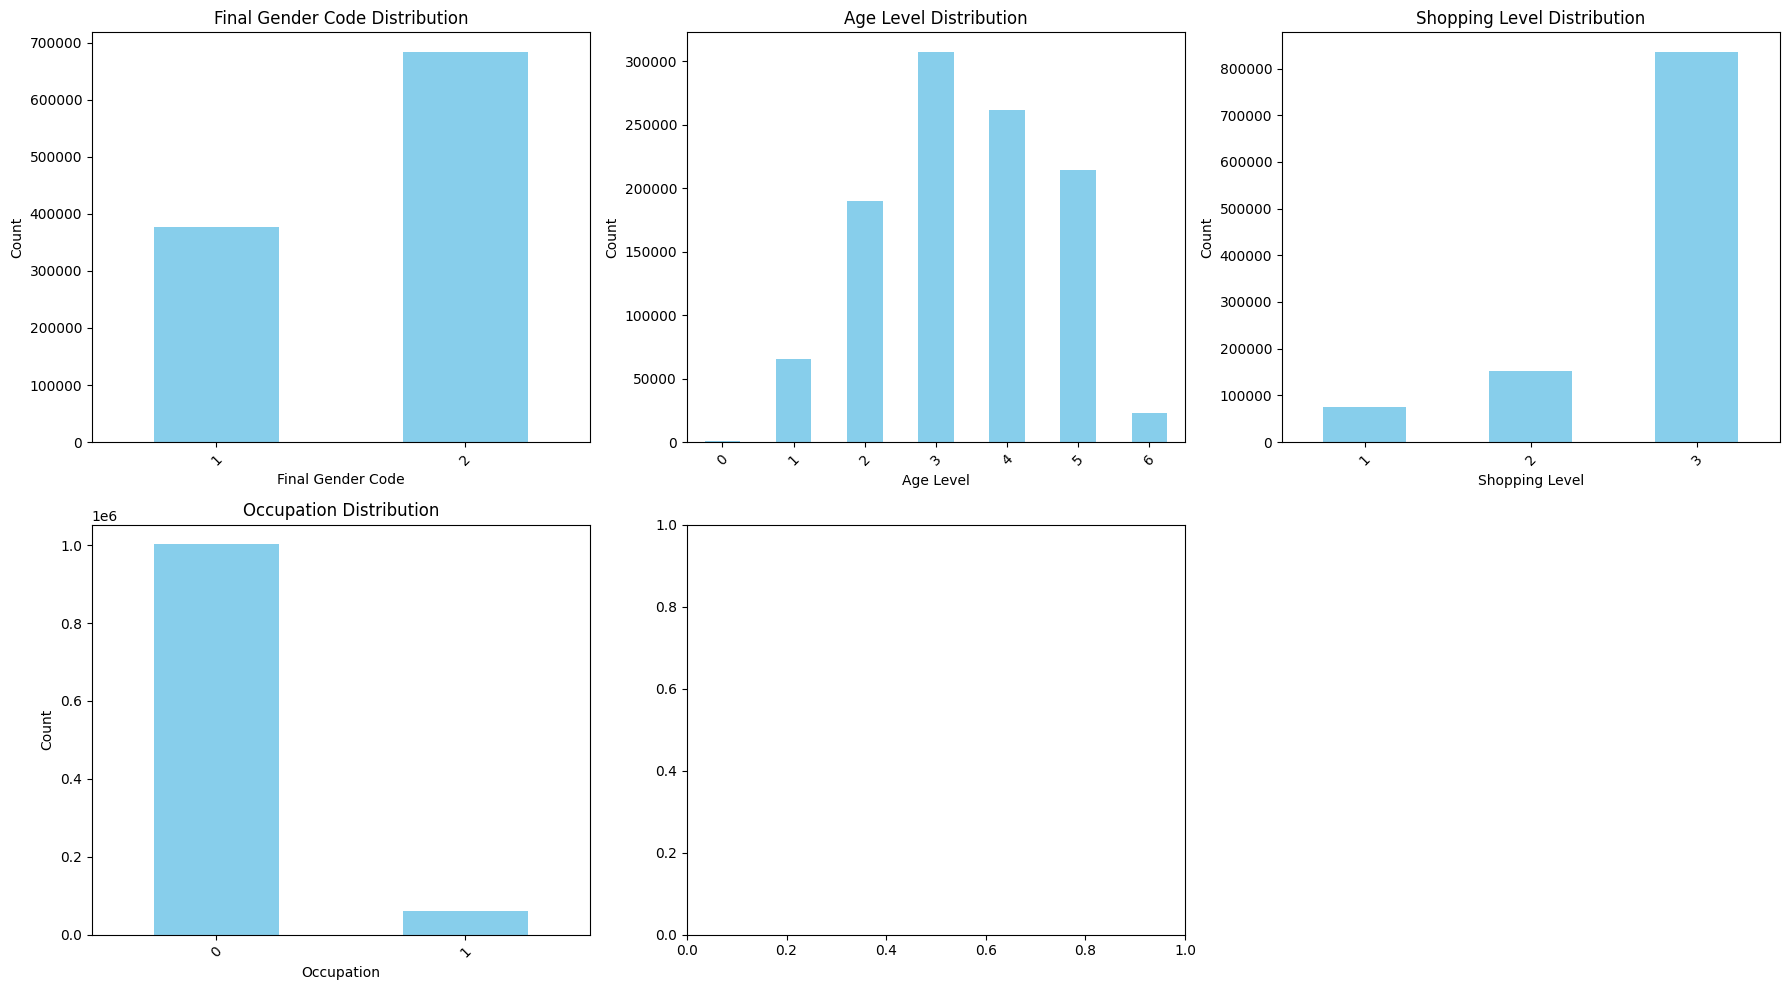


🔗 Gender vs Age Level Cross-tabulation:
age_level            0    1     2     3     4     5    6
final_gender_code                                       
1                  0.1  6.2  16.0  27.2  26.0  22.0  2.5
2                  0.0  6.2  18.9  29.9  23.9  19.2  1.9


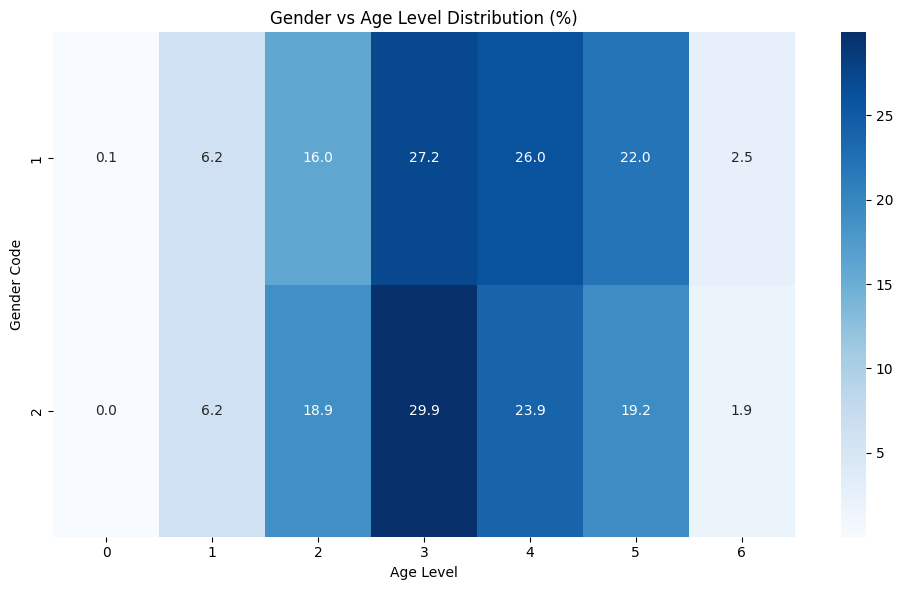

In [ ]:
# Cell 10: User Profile Analysis
def analyze_user_profiles(profile_df):
    """Analyze user demographic profiles"""

    if profile_df is None:
        print("❌ No user profile data available")
        return None

    print("\n👤 USER PROFILE ANALYSIS")
    print("=" * 50)

    print(f"📊 User Profile Overview:")
    print(f"   Total users: {len(profile_df):,}")
    print(f"   Features: {list(profile_df.columns)}")

    # Analyze each demographic feature
    demographic_features = ['final_gender_code', 'age_level', 'shopping_level', 'occupation', 'new_user_class_level']

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, feature in enumerate(demographic_features):
        if feature in profile_df.columns and idx < len(axes):

            # Get value counts
            value_counts = profile_df[feature].value_counts().sort_index()

            print(f"\n📊 {feature.replace('_', ' ').title()} Distribution:")

            # Calculate percentages
            value_pcts = profile_df[feature].value_counts(normalize=True).sort_index() * 100

            for value, count in value_counts.items():
                pct = value_pcts[value] if value in value_pcts else 0
                print(f"   {value}: {count:,} ({pct:.1f}%)")

            # Plot
            if len(value_counts) <= 20:  # Bar plot for categorical
                value_counts.plot(kind='bar', ax=axes[idx], color='skyblue')
                axes[idx].set_title(f'{feature.replace("_", " ").title()} Distribution')
                axes[idx].set_xlabel(feature.replace('_', ' ').title())
                axes[idx].set_ylabel('Count')
                axes[idx].tick_params(axis='x', rotation=45)
            else:  # Histogram for continuous
                profile_df[feature].hist(bins=30, ax=axes[idx], color='skyblue', alpha=0.7)
                axes[idx].set_title(f'{feature.replace("_", " ").title()} Distribution')
                axes[idx].set_xlabel(feature.replace('_', ' ').title())
                axes[idx].set_ylabel('Frequency')

    # Remove empty subplots
    for idx in range(len(demographic_features), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, 'user_demographics.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Cross-tabulation analysis
    if 'final_gender_code' in profile_df.columns and 'age_level' in profile_df.columns:
        print(f"\n🔗 Gender vs Age Level Cross-tabulation:")
        gender_age_crosstab = pd.crosstab(profile_df['final_gender_code'],
                                         profile_df['age_level'],
                                         normalize='index') * 100
        print(gender_age_crosstab.round(1))

        # Heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(gender_age_crosstab, annot=True, fmt='.1f', cmap='Blues')
        plt.title('Gender vs Age Level Distribution (%)')
        plt.xlabel('Age Level')
        plt.ylabel('Gender Code')
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_PATH, 'gender_age_heatmap.png'), dpi=300, bbox_inches='tight')
        plt.show()

    return {
        'total_users': len(profile_df),
        'feature_distributions': {feature: profile_df[feature].value_counts()
                                 for feature in demographic_features
                                 if feature in profile_df.columns}
    }

# Analyze user profiles
if user_profiles is not None:
    profile_analysis = analyze_user_profiles(user_profiles)


🔗 DATA INTEGRATION & RELATIONSHIP ANALYSIS
🛍️ Raw Sample vs Ad Features:
   Ads in raw sample: 243,216
   Ads with features: 846,811
   Overlap: 243,216 (100.0%)
   Missing features: 0
   Extra features: 603,595

👤 Raw Sample vs User Profiles:
   Users in raw sample: 403,381
   Users with profiles: 1,061,768
   Overlap: 378,427 (93.8%)
   Missing profiles: 24,954
   Extra profiles: 683,341

📱 Raw Sample vs User Behavior:
   Users in raw sample: 403,381
   Users with behavior: 527,432
   Overlap: 186,193 (46.2%)


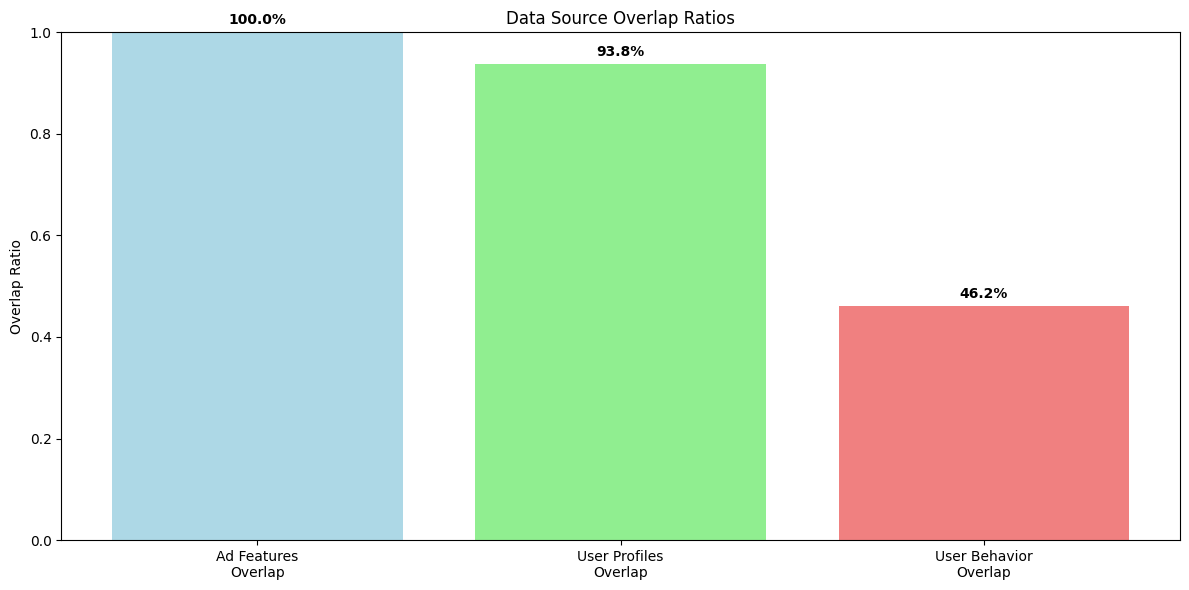

In [ ]:
# Cell 11: Data Integration dan Relationship Analysis
def analyze_data_relationships():
    """Analyze relationships between different data sources"""

    print("\n🔗 DATA INTEGRATION & RELATIONSHIP ANALYSIS")
    print("=" * 60)

    # Check data overlap and relationships
    relationships = {}

    # Raw sample vs Ad features
    if raw_sample is not None and ad_features is not None:
        raw_ads = set(raw_sample['adgroup_id'].unique())
        feature_ads = set(ad_features['adgroup_id'].unique())

        overlap_ads = raw_ads.intersection(feature_ads)
        missing_in_features = raw_ads - feature_ads
        extra_in_features = feature_ads - raw_ads

        print(f"🛍️ Raw Sample vs Ad Features:")
        print(f"   Ads in raw sample: {len(raw_ads):,}")
        print(f"   Ads with features: {len(feature_ads):,}")
        print(f"   Overlap: {len(overlap_ads):,} ({len(overlap_ads)/len(raw_ads)*100:.1f}%)")
        print(f"   Missing features: {len(missing_in_features):,}")
        print(f"   Extra features: {len(extra_in_features):,}")

        relationships['ad_overlap_ratio'] = len(overlap_ads) / len(raw_ads)

    # Raw sample vs User profiles
    if raw_sample is not None and user_profiles is not None:
        raw_users = set(raw_sample['userid'].unique())
        profile_users = set(user_profiles['userid'].unique())

        overlap_users = raw_users.intersection(profile_users)
        missing_profiles = raw_users - profile_users
        extra_profiles = profile_users - raw_users

        print(f"\n👤 Raw Sample vs User Profiles:")
        print(f"   Users in raw sample: {len(raw_users):,}")
        print(f"   Users with profiles: {len(profile_users):,}")
        print(f"   Overlap: {len(overlap_users):,} ({len(overlap_users)/len(raw_users)*100:.1f}%)")
        print(f"   Missing profiles: {len(missing_profiles):,}")
        print(f"   Extra profiles: {len(extra_profiles):,}")

        relationships['user_overlap_ratio'] = len(overlap_users) / len(raw_users)

    # Raw sample vs User behavior
    if raw_sample is not None and user_behavior is not None:
        raw_users_behavior = set(raw_sample['userid'].unique())
        behavior_users = set(user_behavior['userid'].unique())

        overlap_behavior_users = raw_users_behavior.intersection(behavior_users)

        print(f"\n📱 Raw Sample vs User Behavior:")
        print(f"   Users in raw sample: {len(raw_users_behavior):,}")
        print(f"   Users with behavior: {len(behavior_users):,}")
        print(f"   Overlap: {len(overlap_behavior_users):,} ({len(overlap_behavior_users)/len(raw_users_behavior)*100:.1f}%)")

        relationships['behavior_overlap_ratio'] = len(overlap_behavior_users) / len(raw_users_behavior)

    # Visualize relationships
    if relationships:
        plt.figure(figsize=(12, 6))

        # Overlap ratios
        ratios = list(relationships.values())
        labels = ['Ad Features\nOverlap', 'User Profiles\nOverlap', 'User Behavior\nOverlap']
        colors = ['lightblue', 'lightgreen', 'lightcoral']

        bars = plt.bar(labels[:len(ratios)], ratios, color=colors[:len(ratios)])
        plt.title('Data Source Overlap Ratios')
        plt.ylabel('Overlap Ratio')
        plt.ylim(0, 1)

        # Add percentage labels on bars
        for bar, ratio in zip(bars, ratios):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{ratio:.1%}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_PATH, 'data_overlap_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()

    return relationships

# Analyze data relationships
data_relationships = analyze_data_relationships()

In [ ]:
# Cell 12: Save EDA Results
def save_eda_results():
    """Save EDA results for later use"""

    print("\n💾 SAVING EDA RESULTS...")

    # Prepare EDA summary
    eda_results = {
        'timestamp': pd.Timestamp.now(),
        'data_summary': {
            'raw_sample_shape': raw_sample.shape if raw_sample is not None else None,
            'ad_features_shape': ad_features.shape if ad_features is not None else None,
            'user_profiles_shape': user_profiles.shape if user_profiles is not None else None,
            'user_behavior_shape': user_behavior.shape if user_behavior is not None else None,
        },
        'target_analysis': target_analysis if 'target_analysis' in locals() else None,
        'behavior_analysis': behavior_analysis if 'behavior_analysis' in locals() else None,
        'ad_analysis': ad_analysis if 'ad_analysis' in locals() else None,
        'profile_analysis': profile_analysis if 'profile_analysis' in locals() else None,
        'data_relationships': data_relationships if 'data_relationships' in locals() else None,
    }

    # Save to checkpoint
    with open(EDA_CHECKPOINT, 'wb') as f:
        pickle.dump(eda_results, f)

    print(f"✅ EDA results saved to: {EDA_CHECKPOINT}")

    # Create EDA summary report
    summary_lines = [
        "# TAOBAO CTR DATASET - EDA SUMMARY REPORT",
        f"Generated: {pd.Timestamp.now()}",
        "",
        "## Dataset Overview",
    ]

    if raw_sample is not None:
        summary_lines.extend([
            f"- Raw Sample: {raw_sample.shape[0]:,} rows, {raw_sample.shape[1]} columns",
            f"- Date Range: {raw_sample['datetime'].min()} to {raw_sample['datetime'].max()}",
        ])

    if target_analysis:
        imbalance_ratio = target_analysis['imbalance_ratio']
        pos_pct = target_analysis['class_percentage'][1]
        summary_lines.extend([
            "",
            "## Target Variable (CTR)",
            f"- Positive Class (Click): {pos_pct:.2f}%",
            f"- Imbalance Ratio: 1:{imbalance_ratio:.1f}",
            f"- Recommendation: {'Use imbalanced learning techniques' if imbalance_ratio > 10 else 'Moderate imbalance, standard techniques may work'}",
        ])

    if data_relationships:
        summary_lines.extend([
            "",
            "## Data Integration",
            f"- Ad Features Coverage: {data_relationships.get('ad_overlap_ratio', 0):.1%}",
            f"- User Profiles Coverage: {data_relationships.get('user_overlap_ratio', 0):.1%}",
            f"- User Behavior Coverage: {data_relationships.get('behavior_overlap_ratio', 0):.1%}",
        ])

    # Key insights and recommendations
    summary_lines.extend([
        "",
        "## Key Insights & Recommendations",
        "1. **Class Imbalance**: Implement appropriate sampling strategies and loss functions",
        "2. **Temporal Patterns**: Leverage hour-of-day and day-of-week features",
        "3. **User Behavior**: Rich behavioral data available for sequence modeling",
        "4. **Feature Engineering**: Create cyclical temporal features, user behavior aggregations",
        "5. **Model Strategy**: DIN model suitable for user behavior sequence modeling",
    ])

    # Save summary report
    report_path = os.path.join(PLOTS_PATH, 'eda_summary_report.txt')
    with open(report_path, 'w') as f:
        f.write('\n'.join(summary_lines))

    print(f"📋 EDA summary report saved to: {report_path}")
    print("\n🎯 EDA COMPLETED SUCCESSFULLY!")
    print("="*50)
    print("Next steps:")
    print("1. Run preprocessing pipeline")
    print("2. Implement feature engineering")
    print("3. Train DIN, DeepFM, and Basic models")
    print("4. Compare model performance")

    return eda_results

# Save EDA results
eda_results = save_eda_results()
print_memory_status("final")


💾 SAVING EDA RESULTS...
✅ EDA results saved to: /content/drive/MyDrive/TA/TAOBAO/checkpoints/eda_results.pkl
📋 EDA summary report saved to: /content/drive/MyDrive/TA/TAOBAO/plots/eda_summary_report.txt

🎯 EDA COMPLETED SUCCESSFULLY!
Next steps:
1. Run preprocessing pipeline
2. Implement feature engineering
3. Train DIN, DeepFM, and Basic models
4. Compare model performance
💾 Memory usage final: 432.7 MB


432.703125


🔄 SIMPLIFIED SEQUENTIAL BEHAVIOR ANALYSIS
📊 SEQUENCE LENGTH ANALYSIS:
   📈 Sequence Length Statistics:
   Mean: 1.90
   Median: 1
   75th percentile: 2
   95th percentile: 4
   Max: 16

🎯 DIN SEQUENCE LENGTH RECOMMENDATIONS:
   For 80% coverage: max_len = 3
   For 90% coverage: max_len = 4
   Recommended: max_len = 4 (balanced performance)

🔄 BEHAVIOR TRANSITION PATTERNS:
   📊 Transition Probabilities Matrix:
         pv   cart    buy    fav
pv    0.907  0.049  0.017  0.027
cart  0.860  0.101  0.020  0.019
buy   0.870  0.061  0.043  0.026
fav   0.827  0.033  0.016  0.123


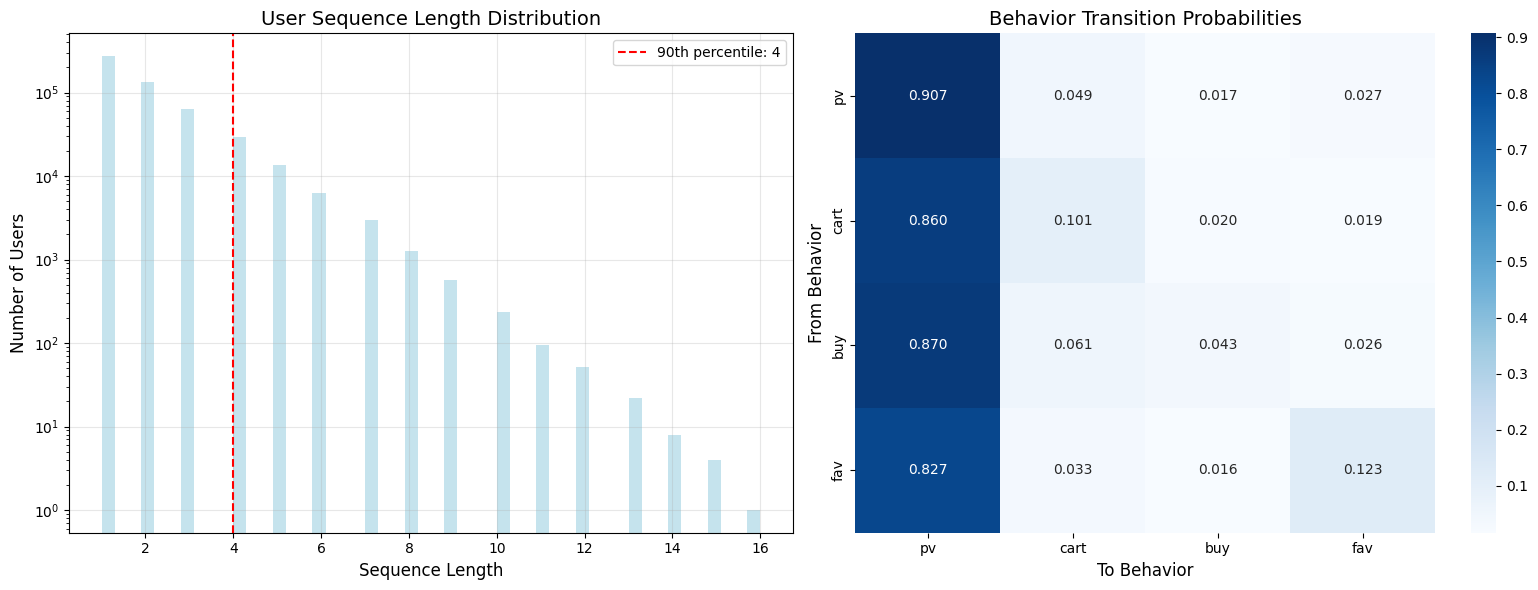

In [ ]:
def analyze_simplified_sequential_behavior(user_behavior):
    """Simplified analysis of user behavior sequences focusing on sequence length
    distribution and behavior transition probabilities"""

    print("\n🔄 SIMPLIFIED SEQUENTIAL BEHAVIOR ANALYSIS")
    print("=" * 70)

    if user_behavior is None:
        print("❌ No user behavior data available")
        return None

    # 1. Sequence Length Distribution Analysis
    print("📊 SEQUENCE LENGTH ANALYSIS:")
    user_sequences = user_behavior.groupby('userid').agg({
        'itemid': lambda x: list(x),
        'categoryid': lambda x: list(x),
        'behavior': lambda x: list(x),
        'timestamp': list
    }).reset_index()

    user_sequences['sequence_length'] = user_sequences['itemid'].apply(len)
    sequence_stats = user_sequences['sequence_length'].describe()

    print(f"   📈 Sequence Length Statistics:")
    print(f"   Mean: {sequence_stats['mean']:.2f}")
    print(f"   Median: {sequence_stats['50%']:.0f}")
    print(f"   75th percentile: {sequence_stats['75%']:.0f}")
    print(f"   95th percentile: {user_sequences['sequence_length'].quantile(0.95):.0f}")
    print(f"   Max: {sequence_stats['max']:.0f}")

    # Optimal sequence length for DIN (capture 80-90% of users)
    optimal_seq_len_80 = user_sequences['sequence_length'].quantile(0.8)
    optimal_seq_len_90 = user_sequences['sequence_length'].quantile(0.9)

    print(f"\n🎯 DIN SEQUENCE LENGTH RECOMMENDATIONS:")
    print(f"   For 80% coverage: max_len = {optimal_seq_len_80:.0f}")
    print(f"   For 90% coverage: max_len = {optimal_seq_len_90:.0f}")
    print(f"   Recommended: max_len = {min(50, optimal_seq_len_90):.0f} (balanced performance)")

    # 2. Behavior Transition Analysis
    print(f"\n🔄 BEHAVIOR TRANSITION PATTERNS:")

    all_transitions = []
    transition_counts = defaultdict(int)

    for _, row in user_sequences.iterrows():
        behaviors = row['behavior']
        if len(behaviors) > 1:
            for i in range(len(behaviors)-1):
                transition = (behaviors[i], behaviors[i+1])
                all_transitions.append(transition)
                transition_counts[transition] += 1

    # Create transition matrix
    behavior_types = user_behavior['behavior'].unique()
    transition_matrix = pd.DataFrame(0, index=behavior_types, columns=behavior_types)

    for (from_behavior, to_behavior), count in transition_counts.items():
        transition_matrix.loc[from_behavior, to_behavior] = count

    # Normalize to get probabilities
    transition_probs = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)

    print("   📊 Transition Probabilities Matrix:")
    print(transition_probs.round(3))

    # Create visualizations for just the two requested charts
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Sequence length distribution
    axes[0].hist(user_sequences['sequence_length'], bins=50, alpha=0.7, color='lightblue')
    axes[0].axvline(optimal_seq_len_90, color='red', linestyle='--',
                   label=f'90th percentile: {optimal_seq_len_90:.0f}')
    axes[0].set_title('User Sequence Length Distribution', fontsize=14)
    axes[0].set_xlabel('Sequence Length', fontsize=12)
    axes[0].set_ylabel('Number of Users', fontsize=12)
    axes[0].set_yscale('log')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # 2. Behavior transition heatmap
    sns.heatmap(transition_probs, annot=True, fmt='.3f', cmap='Blues', ax=axes[1])
    axes[1].set_title('Behavior Transition Probabilities', fontsize=14)
    axes[1].set_xlabel('To Behavior', fontsize=12)
    axes[1].set_ylabel('From Behavior', fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, 'simplified_sequential_analysis.png'),
               dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'sequence_stats': sequence_stats,
        'optimal_seq_len_90': optimal_seq_len_90,
        'transition_matrix': transition_probs
    }

# Run simplified sequential behavior analysis
if user_behavior is not None:
    simplified_analysis = analyze_simplified_sequential_behavior(user_behavior)


🔬 ADVANCED FEATURE ANALYSIS
📱 USER BEHAVIOR SEQUENCE ANALYSIS:
   📊 Sequence Length Stats:
   Mean: 1.9
   Median: 1.0
   Max: 16
   Min: 1

   🔍 Top Sequence Lengths:
   Length 1: 274,335 users (52.0%)
   Length 2: 134,639 users (25.5%)
   Length 3: 63,547 users (12.0%)
   Length 4: 29,681 users (5.6%)
   Length 5: 13,644 users (2.6%)
   Length 6: 6,309 users (1.2%)
   Length 7: 3,002 users (0.6%)
   Length 8: 1,282 users (0.2%)
   Length 9: 573 users (0.1%)
   Length 10: 238 users (0.0%)
   Length 11: 96 users (0.0%)
   Length 12: 51 users (0.0%)
   Length 13: 22 users (0.0%)
   Length 14: 8 users (0.0%)
   Length 15: 4 users (0.0%)
   Length 16: 1 users (0.0%)

   🔄 Behavior Transition Patterns:
   Transition Matrix (%):
to_behavior    buy  cart   fav    pv
from_behavior                       
buy            3.1   3.9   2.3  90.6
cart           1.6  12.5   1.4  84.6
fav            1.6   5.1  10.6  82.7
pv             1.5   4.9   2.4  91.1

   🎯 Sequence Diversity:
   Avg categories

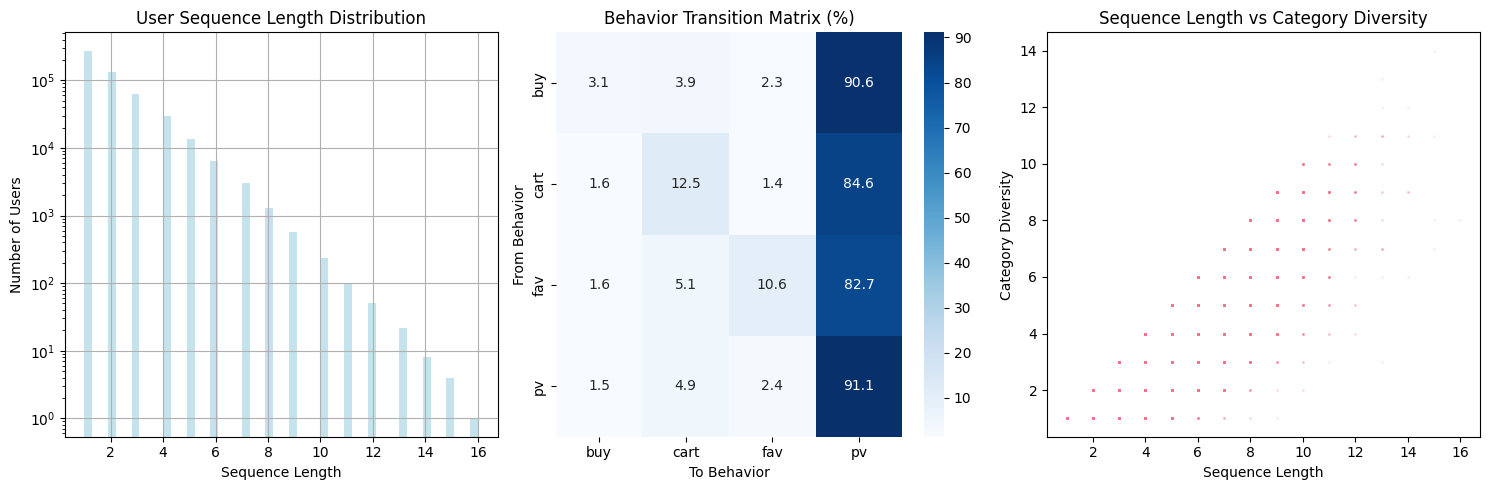

In [ ]:
# Cell 14: Advanced Feature Analysis yang Masih Missing
def advanced_feature_analysis():
    """Analisis mendalam yang masih missing dari EDA current"""

    print("\n🔬 ADVANCED FEATURE ANALYSIS")
    print("=" * 60)

    # 1. User Behavior Sequence Analysis untuk DIN Model
    print("📱 USER BEHAVIOR SEQUENCE ANALYSIS:")

    if user_behavior is not None:
        # Analisis pola sequence yang crucial untuk DIN
        user_sequences = user_behavior.groupby('userid').agg({
            'itemid': lambda x: list(x),
            'categoryid': lambda x: list(x),
            'behavior': lambda x: list(x),
            'timestamp': lambda x: list(x)
        }).reset_index()

        # Sequence length distribution
        user_sequences['sequence_length'] = user_sequences['itemid'].apply(len)

        print(f"   📊 Sequence Length Stats:")
        print(f"   Mean: {user_sequences['sequence_length'].mean():.1f}")
        print(f"   Median: {user_sequences['sequence_length'].median():.1f}")
        print(f"   Max: {user_sequences['sequence_length'].max()}")
        print(f"   Min: {user_sequences['sequence_length'].min()}")

        # Sequence length distribution untuk DIN optimization
        seq_dist = user_sequences['sequence_length'].value_counts().head(20)
        print(f"\n   🔍 Top Sequence Lengths:")
        for length, count in seq_dist.items():
            pct = count / len(user_sequences) * 100
            print(f"   Length {length}: {count:,} users ({pct:.1f}%)")

        # Plot sequence length distribution
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        user_sequences['sequence_length'].hist(bins=50, alpha=0.7, color='lightblue')
        plt.title('User Sequence Length Distribution')
        plt.xlabel('Sequence Length')
        plt.ylabel('Number of Users')
        plt.yscale('log')

        # Behavior transition analysis
        print(f"\n   🔄 Behavior Transition Patterns:")
        all_sequences = []
        for behaviors in user_sequences['behavior'].head(10000):  # Sample for performance
            if len(behaviors) > 1:
                for i in range(len(behaviors)-1):
                    all_sequences.append((behaviors[i], behaviors[i+1]))

        transition_df = pd.DataFrame(all_sequences, columns=['from_behavior', 'to_behavior'])
        transition_matrix = pd.crosstab(transition_df['from_behavior'],
                                      transition_df['to_behavior'],
                                      normalize='index') * 100

        print("   Transition Matrix (%):")
        print(transition_matrix.round(1))

        # Plot transition matrix
        plt.subplot(1, 3, 2)
        sns.heatmap(transition_matrix, annot=True, fmt='.1f', cmap='Blues')
        plt.title('Behavior Transition Matrix (%)')
        plt.xlabel('To Behavior')
        plt.ylabel('From Behavior')

        # Category diversity in sequences
        user_sequences['category_diversity'] = user_sequences['categoryid'].apply(lambda x: len(set(x)))
        user_sequences['item_diversity'] = user_sequences['itemid'].apply(lambda x: len(set(x)))

        print(f"\n   🎯 Sequence Diversity:")
        print(f"   Avg categories per user: {user_sequences['category_diversity'].mean():.1f}")
        print(f"   Avg unique items per user: {user_sequences['item_diversity'].mean():.1f}")

        # Plot diversity
        plt.subplot(1, 3, 3)
        plt.scatter(user_sequences['sequence_length'], user_sequences['category_diversity'],
                   alpha=0.1, s=1)
        plt.xlabel('Sequence Length')
        plt.ylabel('Category Diversity')
        plt.title('Sequence Length vs Category Diversity')

        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_PATH, 'sequence_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()

        return user_sequences

    return None

# Run advanced analysis
user_sequences = advanced_feature_analysis()